# Udacity Project 5 - Identifying Persons of Interests (POIs) in Enron fraud case

## Goal of project

The goal of this project is to be able to identify the POIs of the Enron fraud cases, through examining the financial and email data of persons involved. We will be using the data to train machine learning models and use the models to predict the likelihood of an individual being a POI.

## Background of data

The data set used included financial and email data from 145 individuals involved in the case and 20 features such as salary, bonus, expenses, emails sent and emails received.

In [1]:
#!/usr/bin/python

%matplotlib inline
import sys
import pickle


sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import numpy as np
import seaborn as sns
import math

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score
from sklearn.grid_search import GridSearchCV

from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, precision_score, recall_score

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import FunctionTransformer

## Setting up the data

In [7]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','bonus', 'salary'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [8]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import pandas as pd
import numpy as np
import math

from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

from sklearn.metrics import f1_score
from sklearn.grid_search import GridSearchCV


### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

data_list = ['poi',
 'total_stock_value',
 'total_payments',
 'restricted_stock',
 'exercised_stock_options',
 'expenses',
 'salary',
 'other',
 'to_messages',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'bonus',
 'exp_sal_ratio',
 'to_poi_ratio', 
 'from_poi_ratio', 
 'shared_poi_ratio']

features_list = ['poi',
 'total_stock_value',
 'total_payments',
 'restricted_stock',
 'exercised_stock_options',
 'expenses',
 'salary',
 'other',
 'to_messages',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'bonus']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers

# total of all 145 entries need to be removed
del data_dict['TOTAL']

# Travel agency was not an employee
del data_dict['THE TRAVEL AGENCY IN THE PARK']

# The following 2 individual didn't had tally in the sum of all finance and email features with their respective total
del data_dict['BELFER ROBERT']
del data_dict['BHATNAGAR SANJAY']

# This individual, non-POI, had abnormally high expenses compared to a meagre salary
#del data_dict['FREVERT MARK A']

# Converting to pandas dataframe
df = pd.DataFrame(data_dict)
df = df.T.reset_index()

# Remove "email address" column
del df['email_address']

# Replacing NaN values with np.nan and convert all number features to float type
df.replace('NaN',np.nan, inplace = True)
df.iloc[:,1:] = df.iloc[:,1:].astype(float)
df.replace(np.nan, 0, inplace = True)

### Task 3: Create new feature(s)

# Expenses salary ratio
df['exp_sal_ratio'] = df['expenses'] / df['salary']
df.loc[:, 'exp_sal_ratio'] = df['exp_sal_ratio'].apply(lambda x: 0 if ((x == np.inf) or (math.isnan(x))) else x)

# ratio of emails to poi to total emails sent
df['to_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']
df.loc[:, 'to_poi_ratio'] = df['to_poi_ratio'].apply(lambda x: 0 if ((x == np.inf) or (math.isnan(x))) else x)

# ratio of emails from poi to total emails received
df['from_poi_ratio'] = df['from_poi_to_this_person'] / df['to_messages']
df.loc[:, 'from_poi_ratio'] = df['from_poi_ratio'].apply(lambda x: 0 if ((x == np.inf) or (math.isnan(x))) else x)

# ratio of shared receipt emails with poi to total emails received
df['shared_poi_ratio'] = df['shared_receipt_with_poi'] / df['to_messages']
df.loc[:, 'shared_poi_ratio'] = df['shared_poi_ratio'].apply(lambda x: 0 if ((x == np.inf) or (math.isnan(x))) else x)

### Store to my_dataset for easy export below.
my_dataset = df.T[df.columns.isin(data_list)].to_dict()

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

# Setting up X and y for modeling

rand_state = 42
y = df['poi']
X = df.T[df.columns.isin(features_list)].T.drop(['poi'], axis = 1)

X.head(20)

# Gridsearch for GaussianNB


,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,4.175e+06,1.72954e+06,13868,2195,47,65,152,126027,201955,1407,2902,4.48444e+06,1.72954e+06
1,0,257817,3486,0,0,0,0,0,0,0,0,182466,257817
2,0,4.04616e+06,56301,29,39,0,864523,1.75755e+06,477,465,566,916197,5.24349e+06
3,1.2e+06,6.68054e+06,11200,0,0,0,2.6603e+06,3.94271e+06,267102,0,0,5.63434e+06,1.06233e+07
4,400000,0,129142,0,0,0,69,145796,239671,0,0,827696,63014
5,0,1.59964e+06,0,0,0,0,874,0,80818,0,0,860136,1.59964e+06
6,700000,0,37172,4343,144,386,566,126027,231330,2639,7315,969068,126027
7,5.25e+06,953136,17355,484,228,108,210698,157569,213999,5521,7991,5.50163e+06,1.11070e+06
8,0,1.6244e+06,11892,0,0,0,0,869220,216582,0,0,228474,2.49362e+06
9,250000,0,59175,59,4,0,427316,659249,187922,233,383,618850,659249


In [9]:

combined_features = FeatureUnion([("kbest", SelectKBest()), ("pca", PCA())])

k = [5,6,7,8, 9, 10, 11,12,13]
n_components = [2,3,4,5,6]

pipeline = Pipeline([("standard_scale", MinMaxScaler()),("features", combined_features), ("gnb", GaussianNB())])
param_grid_neigh = dict(features__pca__n_components=n_components, \
                  features__kbest__k=k)

sss = StratifiedShuffleSplit(y, n_iter=100, test_size=0.3, random_state = rand_state)

gsgnb = GridSearchCV(pipeline, \
                    param_grid_neigh, \
                    scoring= 'f1', cv=sss, n_jobs = -1
                   )

gsgnb.fit(X,y)

clf = gsgnb.best_estimator_

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!


### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [6]:
gsgnb.best_score_

0.35312328512560714

In [10]:
gsgnb.best_score_

0.34280866355866368

In [5]:
len(data_dict)

146

In [6]:
del data_dict['TOTAL']

In [7]:
len(data_dict)

145

## Putting the data into a pandas dataframe for easy manipulation

In [172]:
df = pd.DataFrame(data_dict)
df = df.T.reset_index()
df.head()

,index,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
1,BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
2,BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
3,BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
4,BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


## Checking the shape of the df

In [173]:
df.shape

(146, 22)

## Checking POIs vs Non-POIs

In [174]:
print df['poi'].value_counts()
print df['poi'].value_counts()[1]/float(df.shape[0])

False    128
True      18
Name: poi, dtype: int64
0.123287671233


#### Comments:

Since only about 12% of the data were POIs, there is an imbalance in the distribution of POIs. This may cause problems in modeling later, specifically in the selection of model performance metric. Accuracy should not be used since the baseline accuracy, by calling all non-pois, is already at about 88%. However, such a model would not be able to catch any POIs since every input would be classified as a non-POI.

## Removing non-essential column: email address

In [175]:
del df['email_address']

In [176]:
df.shape

(146, 21)

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 21 columns):
index                        146 non-null object
bonus                        146 non-null object
deferral_payments            146 non-null object
deferred_income              146 non-null object
director_fees                146 non-null object
exercised_stock_options      146 non-null object
expenses                     146 non-null object
from_messages                146 non-null object
from_poi_to_this_person      146 non-null object
from_this_person_to_poi      146 non-null object
loan_advances                146 non-null object
long_term_incentive          146 non-null object
other                        146 non-null object
poi                          146 non-null object
restricted_stock             146 non-null object
restricted_stock_deferred    146 non-null object
salary                       146 non-null object
shared_receipt_with_poi      146 non-null object
to_messages  

#### Comments:

Seems that the values in the df are all strings. Need to convert the NaNs to np.nan and the rest of the values to float.

## Converting all numeric values to float

In [178]:
df.replace('NaN',np.nan, inplace = True)
df.head()

,index,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,ALLEN PHILLIP K,4175000.0,2869717.0,-3081055.0,NaN,1729541.0,13868.0,2195.0,47.0,65.0,...,304805.0,152.0,False,126027.0,-126027.0,201955.0,1407.0,2902.0,4484442.0,1729541.0
1,BADUM JAMES P,NaN,178980.0,NaN,NaN,257817.0,3486.0,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466.0,257817.0
2,BANNANTINE JAMES M,NaN,NaN,-5104.0,NaN,4046157.0,56301.0,29.0,39.0,0.0,...,NaN,864523.0,False,1757552.0,-560222.0,477.0,465.0,566.0,916197.0,5243487.0
3,BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,NaN,6680544.0,11200.0,NaN,NaN,NaN,...,1586055.0,2660303.0,False,3942714.0,NaN,267102.0,NaN,NaN,5634343.0,10623258.0
4,BAY FRANKLIN R,400000.0,260455.0,-201641.0,NaN,NaN,129142.0,NaN,NaN,NaN,...,NaN,69.0,False,145796.0,-82782.0,239671.0,NaN,NaN,827696.0,63014.0


In [179]:
df.iloc[:,1:] = df.iloc[:,1:].astype(float)
df.dtypes

index                         object
bonus                        float64
deferral_payments            float64
deferred_income              float64
director_fees                float64
exercised_stock_options      float64
expenses                     float64
from_messages                float64
from_poi_to_this_person      float64
from_this_person_to_poi      float64
loan_advances                float64
long_term_incentive          float64
other                        float64
poi                          float64
restricted_stock             float64
restricted_stock_deferred    float64
salary                       float64
shared_receipt_with_poi      float64
to_messages                  float64
total_payments               float64
total_stock_value            float64
dtype: object

# Checking for missing data

In [180]:
(df.isnull().sum(axis =0)/len(df)).sort_values()

index                        0.000000
poi                          0.000000
total_stock_value            0.136986
total_payments               0.143836
restricted_stock             0.246575
exercised_stock_options      0.301370
expenses                     0.349315
salary                       0.349315
other                        0.363014
to_messages                  0.410959
from_messages                0.410959
from_poi_to_this_person      0.410959
from_this_person_to_poi      0.410959
shared_receipt_with_poi      0.410959
bonus                        0.438356
long_term_incentive          0.547945
deferred_income              0.664384
deferral_payments            0.732877
restricted_stock_deferred    0.876712
director_fees                0.883562
loan_advances                0.972603
dtype: float64

In [181]:
want_list = list((df.isnull().sum(axis =0)/len(df)).sort_values()[(df.isnull().sum(axis =0)/len(df)).sort_values() < 0.5].index)

#### Comments:

We see that some features had a large percentage of missing data. Although the threshold value is arbituary, I am inclined to disregard features with more than halve of missing values. The rationale is that error is introduced with any kind of imputation strategy. So by introducing error into over 50% of the data in a feature, a coin-flip event may have a better chance of classifying a binary outcome.

On imputation strategy, going back to the pdf file, it seemed reasonable to assume that these NaN values may correspond to the individual not receiving that particular payment or stock option, hence I chose to replace the NaNs with zeros.

## Replacing NaN with zero

In [182]:
df.replace(np.nan, 0, inplace = True)
df.head()

,index,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,ALLEN PHILLIP K,4175000.0,2869717.0,-3081055.0,0.0,1729541.0,13868.0,2195.0,47.0,65.0,...,304805.0,152.0,0.0,126027.0,-126027.0,201955.0,1407.0,2902.0,4484442.0,1729541.0
1,BADUM JAMES P,0.0,178980.0,0.0,0.0,257817.0,3486.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182466.0,257817.0
2,BANNANTINE JAMES M,0.0,0.0,-5104.0,0.0,4046157.0,56301.0,29.0,39.0,0.0,...,0.0,864523.0,0.0,1757552.0,-560222.0,477.0,465.0,566.0,916197.0,5243487.0
3,BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,...,1586055.0,2660303.0,0.0,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0
4,BAY FRANKLIN R,400000.0,260455.0,-201641.0,0.0,0.0,129142.0,0.0,0.0,0.0,...,0.0,69.0,0.0,145796.0,-82782.0,239671.0,0.0,0.0,827696.0,63014.0


#### Comments:

Now that the data is in a somewhat decent shape, we can proceed to do some EDA to identify the outliers.

## Exploring the data and removing outliers

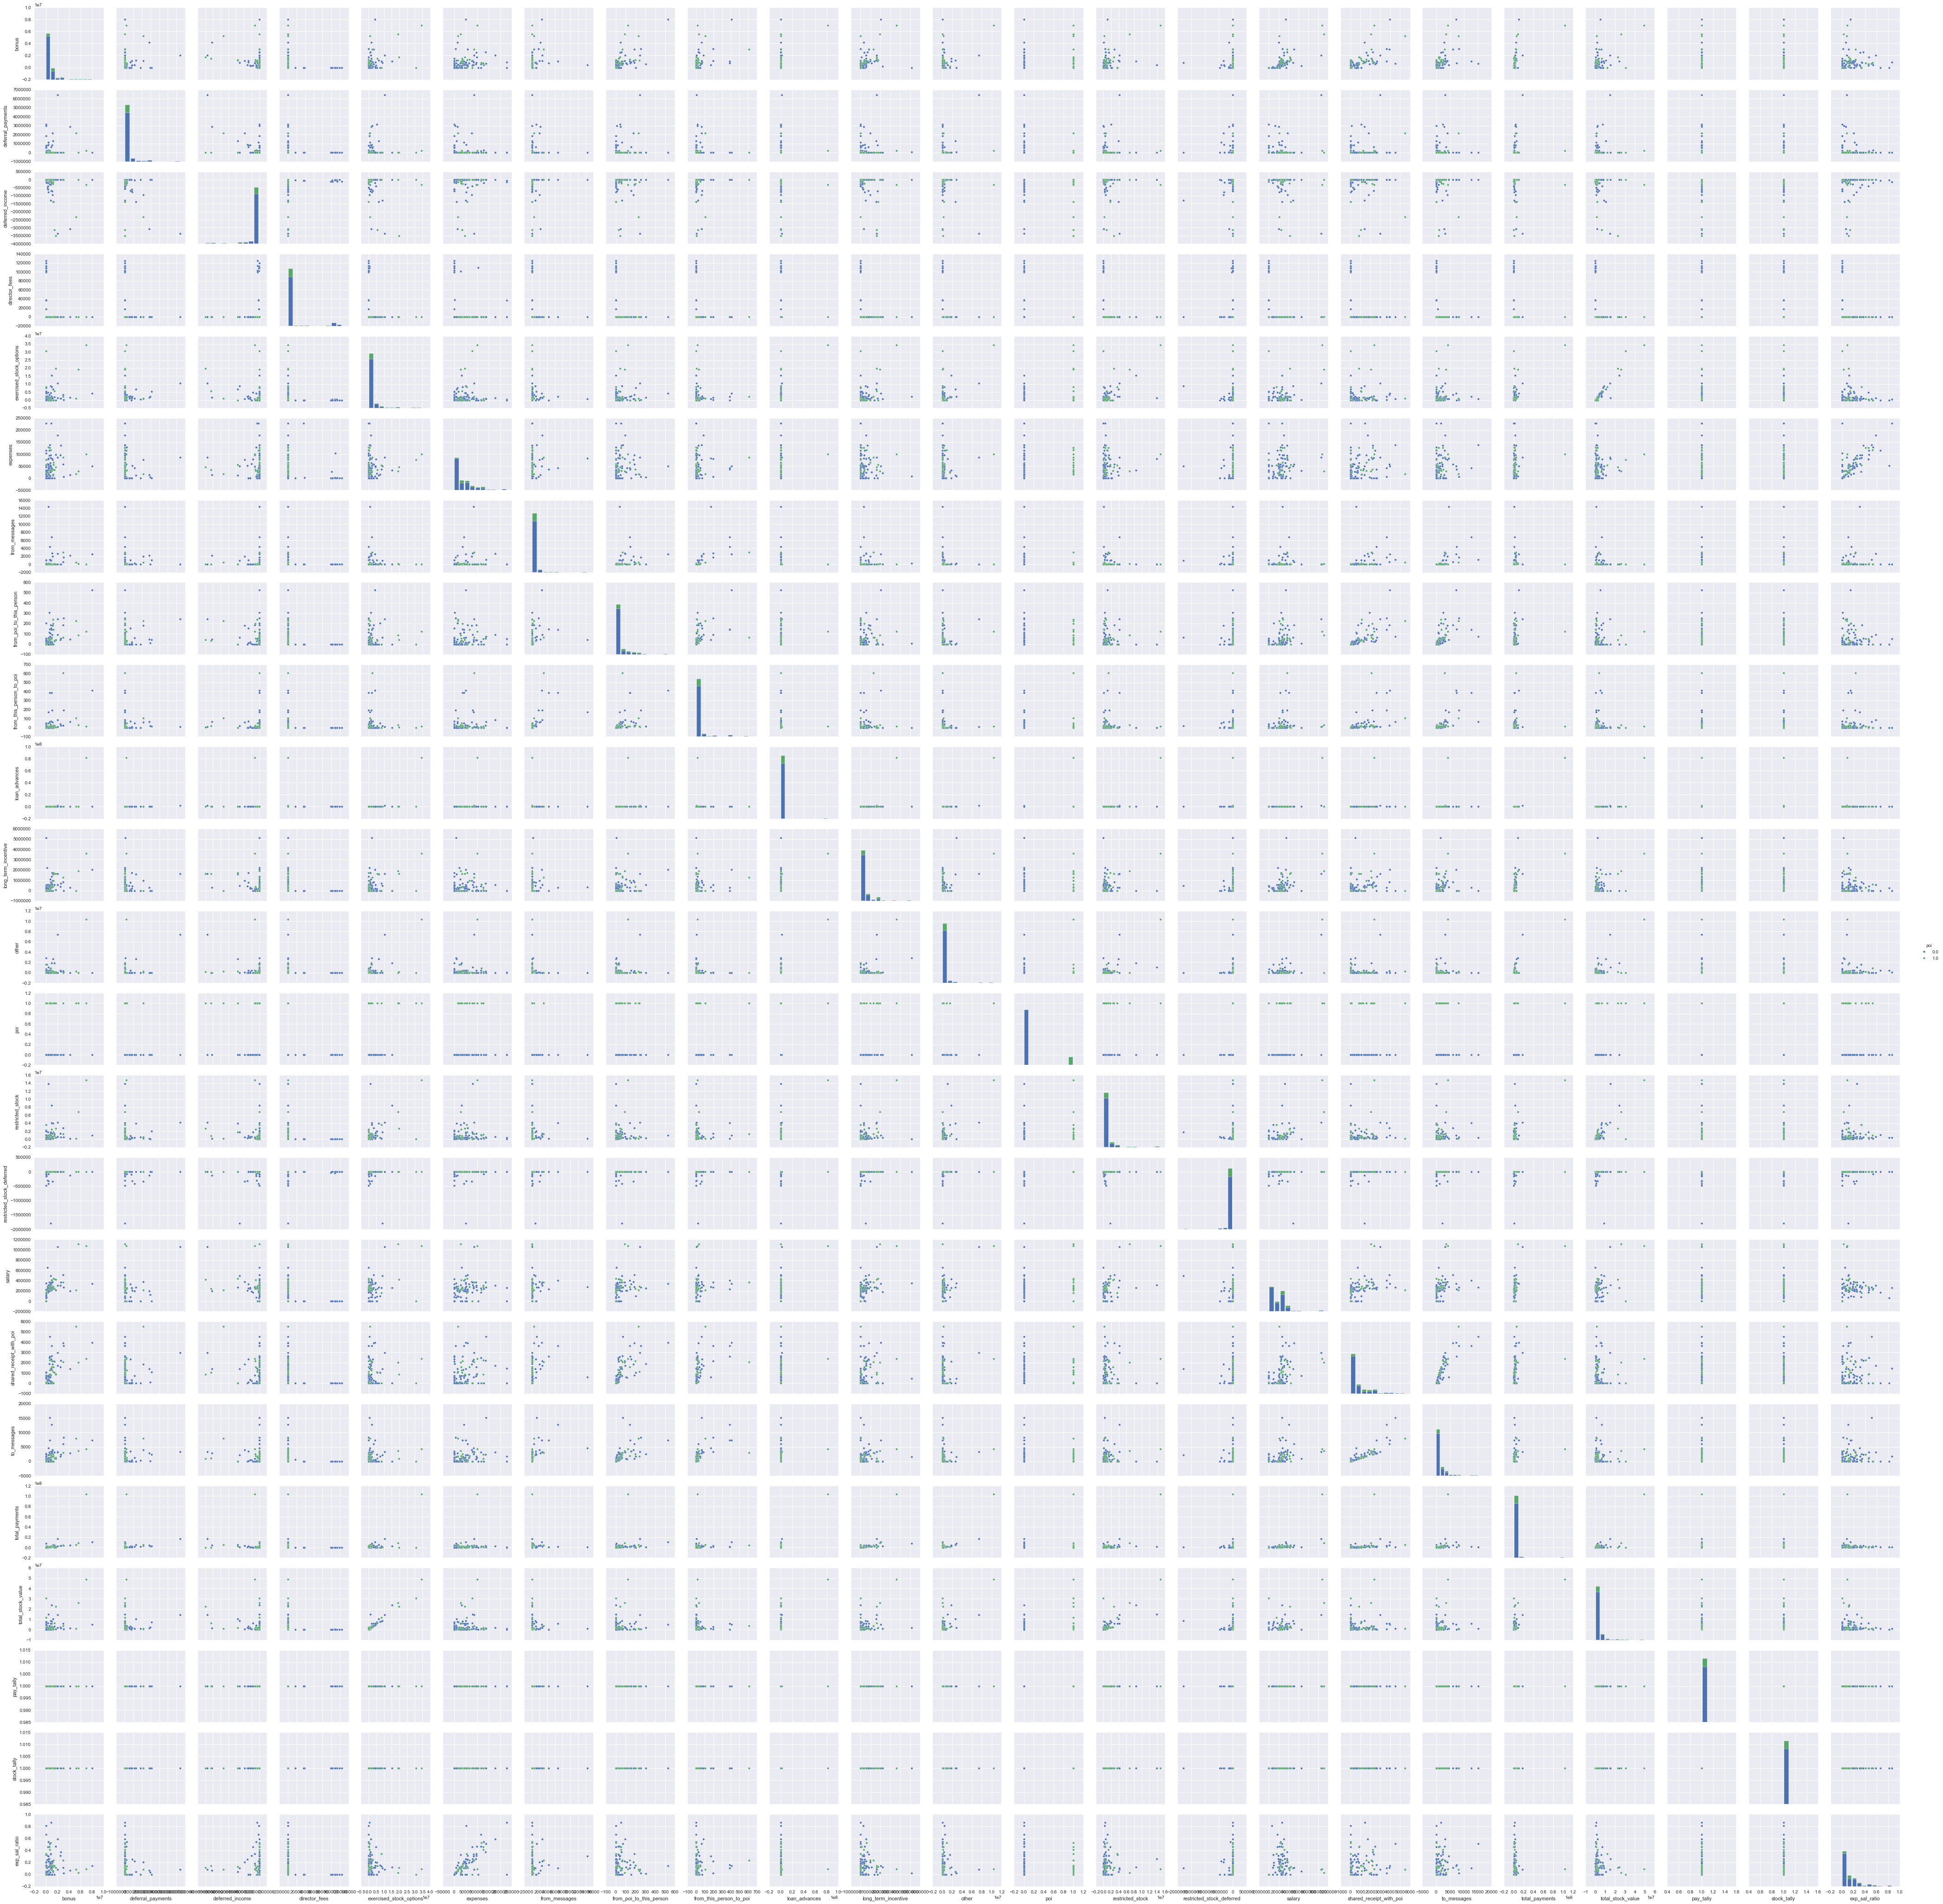

In [120]:
sns.pairplot(df, hue='poi')

#### Comments:

The pairplot did not indicate any feature which strongly separate POIs and Non-POIs. However, the scatterplots did indicate some extreme outliers.

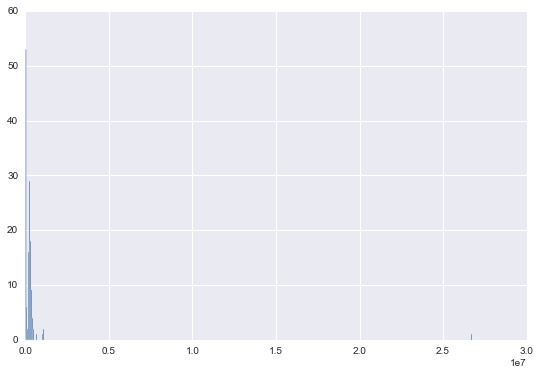

In [183]:
# Zooming into salary

df['salary'].hist(bins = 500)

# We note an extreme outlier

In [184]:
# Examining outlier

df[df['salary'] > 2.5e7]

# From pdf file, this corresponded to "TOTAL", will drop this row

,index,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
130,TOTAL,97343619.0,32083396.0,-27992891.0,1398517.0,311764000.0,5235198.0,0.0,0.0,0.0,...,48521928.0,42667589.0,0.0,130322299.0,-7576788.0,26704229.0,0.0,0.0,309886585.0,434509511.0


In [185]:
# From pdf file, there is a travel agency in the payment list as well, we will also drop that row.

df[df['total_payments'] == 362096]

,index,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
127,THE TRAVEL AGENCY IN THE PARK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,362096.0,0.0,0.0,0.0,0.0,0.0,0.0,362096.0,0.0


In [186]:
df.drop(df.index[[127, 130]], inplace=True)

## Checking total payments and total stock values

In [187]:
df['pay_tally'] = df['salary'] + df['bonus'] + \
                    df['long_term_incentive'] + df['deferred_income'] + \
                    df['deferral_payments'] + df['loan_advances'] + \
                    df['other'] + df['expenses'] + df['director_fees'] \
            == df['total_payments']

In [188]:
df['stock_tally'] = df['exercised_stock_options'] + df['restricted_stock'] \
                    + df['restricted_stock_deferred'] \
                    == df['total_stock_value']

In [189]:
df[df['pay_tally'] == False]

,index,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,pay_tally,stock_tally
8,BELFER ROBERT,0.0,-102500.0,0.0,3285.0,3285.0,0.0,0.0,0.0,0.0,...,0.0,0.0,44093.0,0.0,0.0,0.0,102500.0,-44093.0,False,False
11,BHATNAGAR SANJAY,0.0,0.0,0.0,137864.0,2604490.0,0.0,29.0,0.0,1.0,...,0.0,-2604490.0,15456290.0,0.0,463.0,523.0,15456290.0,0.0,False,False


In [190]:
df[df['stock_tally'] == False]

,index,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,pay_tally,stock_tally
8,BELFER ROBERT,0.0,-102500.0,0.0,3285.0,3285.0,0.0,0.0,0.0,0.0,...,0.0,0.0,44093.0,0.0,0.0,0.0,102500.0,-44093.0,False,False
11,BHATNAGAR SANJAY,0.0,0.0,0.0,137864.0,2604490.0,0.0,29.0,0.0,1.0,...,0.0,-2604490.0,15456290.0,0.0,463.0,523.0,15456290.0,0.0,False,False


In [191]:
df.drop(df.index[[8, 11]], inplace=True)

#### Comments:

We note that two same persons had non-tally total payment and stock. We further note that these two individuals were non-pois. Therefore, we deleted them from the data.

## Creating new features

In [195]:
# Expenses salary ratio

# Should be a typically small value, higher earners expense more
# Anormaly may have some predictive abilties

df['exp_sal_ratio'] = df['expenses'] / df['salary']

In [196]:
# Converting nan and infinity entries to zero

df.loc[:, 'exp_sal_ratio'] = df['exp_sal_ratio'].apply(lambda x: 0 if ((x == np.inf) or (math.isnan(x))) else x)
df.head()

,index,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,pay_tally,stock_tally,exp_sal_ratio
0,ALLEN PHILLIP K,4175000.0,2869717.0,-3081055.0,0.0,1729541.0,13868.0,2195.0,47.0,65.0,...,126027.0,-126027.0,201955.0,1407.0,2902.0,4484442.0,1729541.0,True,True,0.068669
1,BADUM JAMES P,0.0,178980.0,0.0,0.0,257817.0,3486.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,182466.0,257817.0,True,True,0.000000
2,BANNANTINE JAMES M,0.0,0.0,-5104.0,0.0,4046157.0,56301.0,29.0,39.0,0.0,...,1757552.0,-560222.0,477.0,465.0,566.0,916197.0,5243487.0,True,True,118.031447
3,BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,...,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0,True,True,0.041932
4,BAY FRANKLIN R,400000.0,260455.0,-201641.0,0.0,0.0,129142.0,0.0,0.0,0.0,...,145796.0,-82782.0,239671.0,0.0,0.0,827696.0,63014.0,True,True,0.538830


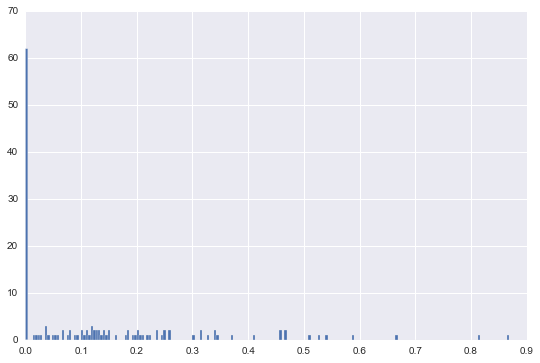

In [197]:
df[df['exp_sal_ratio']< 100]['exp_sal_ratio'].hist(bins = 200)

In [198]:
df[df['exp_sal_ratio'] > 100]

,index,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,pay_tally,stock_tally,exp_sal_ratio
2,BANNANTINE JAMES M,0.0,0.0,-5104.0,0.0,4046157.0,56301.0,29.0,39.0,0.0,...,1757552.0,-560222.0,477.0,465.0,566.0,916197.0,5243487.0,True,True,118.031447


In [199]:
df[df['exp_sal_ratio'] > 100]['poi']

2    0.0
Name: poi, dtype: float64

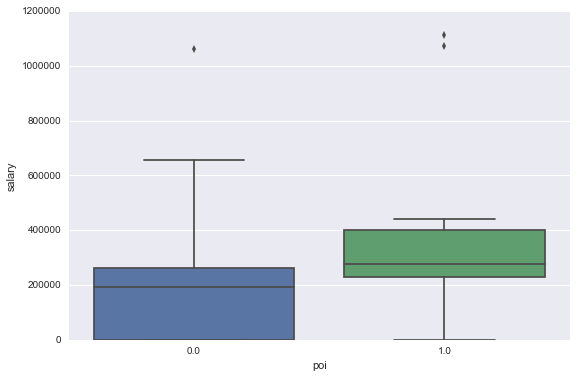

In [250]:
sns.boxplot(x = 'poi', y = 'salary', data = df)

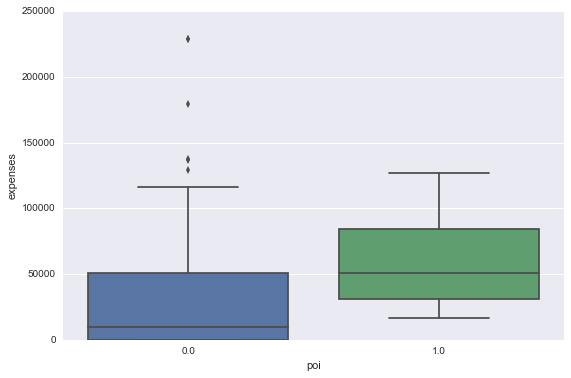

In [201]:
sns.boxplot(x = 'poi', y = 'expenses', data = df)

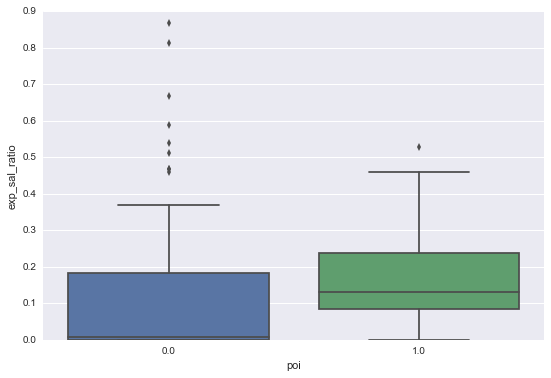

In [202]:
sns.boxplot(x = 'poi', y = 'exp_sal_ratio', data = df)

#### Comments:

Expense salary ratio was created as a new feature as we would expect typical expenses to be less than salary. For an average individual, expenses should be a low, reasonable amount, compared to salary. For POIs, there may be an increased likelihood that they might have charged an astronomical amount, since expenses may be harder to account for than salary.

Expenses by itself may not be able to predict this properly since some executive may have to entertain clients and hence may end up with larger expense account. However, we should expect the expenses to commensurate their salaries. A high performer (higher salary) bringing in large account may be entitled to expense more.

## POI email ratios

#### Comments:

Additional email features were added. Instead of just using the absolute number of emails to and from POIs, a ratio of POI emails over total to and from emails were used. An individual may simply be sending a lot of emails, including a large number to POIs, however, proportionately, the emails to POI account for a comparatively low proportion of the total emails he sent. Therefore, POI email ratios should be a better gauge of the relationship between an individual and the POIs.

In [203]:
# ratio of emails to poi to total emails sent

df['to_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']

In [204]:
# ratio of emails from poi to total emails received

df['from_poi_ratio'] = df['from_poi_to_this_person'] / df['to_messages']

In [205]:
# ratio of shared receipt emails with poi to total emails received

df['shared_poi_ratio'] = df['shared_receipt_with_poi'] / df['to_messages']

In [206]:
# Converting nan and infinity entries to zero

df.loc[:, 'to_poi_ratio'] = df['to_poi_ratio'].apply(lambda x: 0 if ((x == np.inf) or (math.isnan(x))) else x)
df.loc[:, 'from_poi_ratio'] = df['from_poi_ratio'].apply(lambda x: 0 if ((x == np.inf) or (math.isnan(x))) else x)
df.loc[:, 'shared_poi_ratio'] = df['shared_poi_ratio'].apply(lambda x: 0 if ((x == np.inf) or (math.isnan(x))) else x)
df.head()

,index,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,pay_tally,stock_tally,exp_sal_ratio,to_poi_ratio,from_poi_ratio,shared_poi_ratio
0,ALLEN PHILLIP K,4175000.0,2869717.0,-3081055.0,0.0,1729541.0,13868.0,2195.0,47.0,65.0,...,1407.0,2902.0,4484442.0,1729541.0,True,True,0.068669,0.029613,0.016196,0.484838
1,BADUM JAMES P,0.0,178980.0,0.0,0.0,257817.0,3486.0,0.0,0.0,0.0,...,0.0,0.0,182466.0,257817.0,True,True,0.000000,0.000000,0.000000,0.000000
3,BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,...,0.0,0.0,5634343.0,10623258.0,True,True,0.041932,0.000000,0.000000,0.000000
4,BAY FRANKLIN R,400000.0,260455.0,-201641.0,0.0,0.0,129142.0,0.0,0.0,0.0,...,0.0,0.0,827696.0,63014.0,True,True,0.538830,0.000000,0.000000,0.000000
5,BAZELIDES PHILIP J,0.0,684694.0,0.0,0.0,1599641.0,0.0,0.0,0.0,0.0,...,0.0,0.0,860136.0,1599641.0,True,True,0.000000,0.000000,0.000000,0.000000


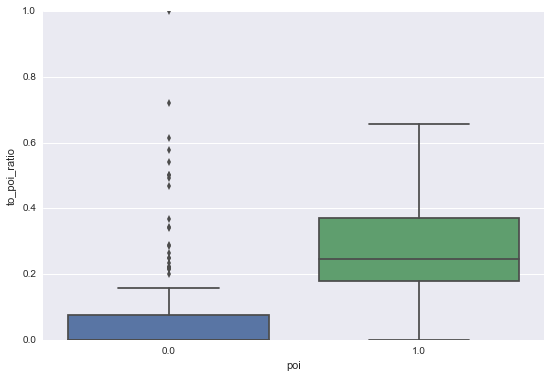

In [207]:
# Proportional to POI

sns.boxplot(x = 'poi', y = 'to_poi_ratio', data = df)

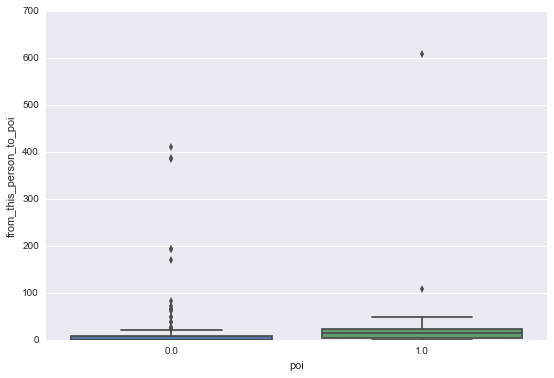

In [208]:
# Absolute to POI

sns.boxplot(x = 'poi', y = 'from_this_person_to_poi', data = df)

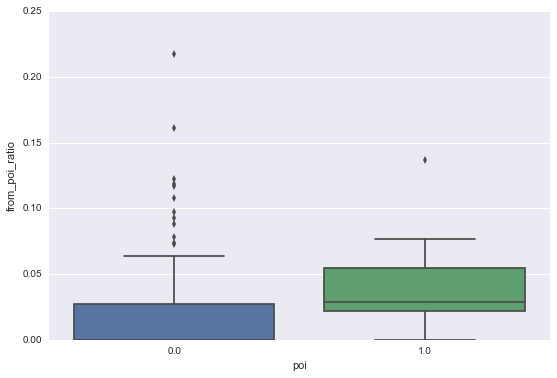

In [209]:
# Proportional from poi

sns.boxplot(x = 'poi', y = 'from_poi_ratio', data = df)

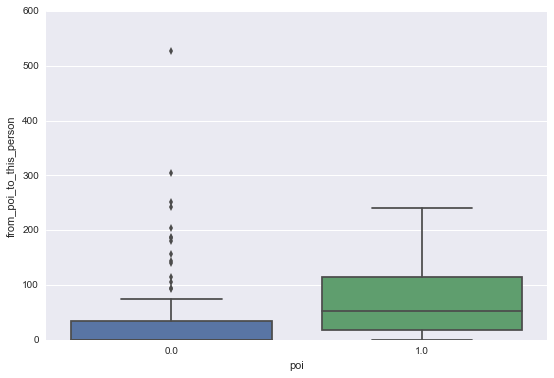

In [210]:
# Absolute from POI

sns.boxplot(x = 'poi', y = 'from_poi_to_this_person', data = df)

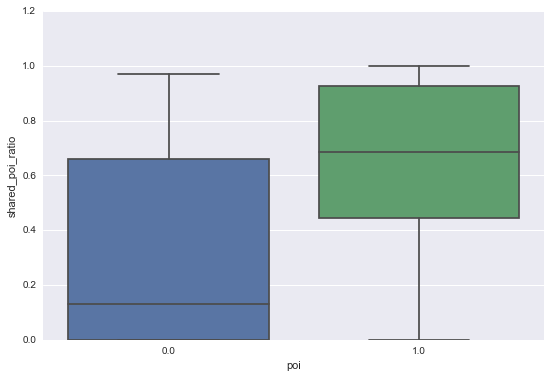

In [211]:
# Proportional shared receipt

sns.boxplot(x = 'poi', y = 'shared_poi_ratio', data = df)

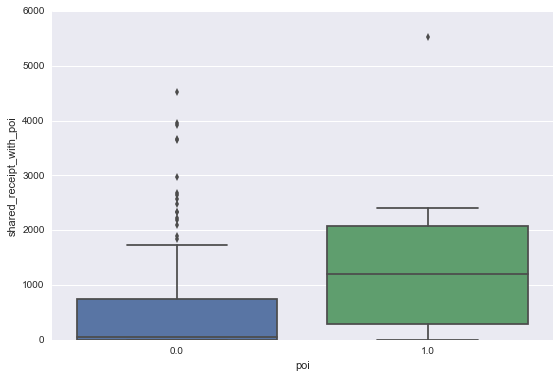

In [212]:
# Absolute shared receipt

sns.boxplot(x = 'poi', y = 'shared_receipt_with_poi', data = df)

#### Comments:

Firstly, the boxplots showed that POIs had a tendency to be sending, receiving and sharing-receipt of more emails amongst themselves than with non-POIs, hence these new features should have better predictive abilities.

Secondly, the proportional plots had increased discriminatory effects on POIs as well as smoothing the outliers of the non-POIs. This should also improve predictability.

## Creating new list of features to go into models

In [213]:
df.columns = ['name'] + list(df.columns)[1:]

In [214]:
df.set_index('name', inplace=True)

In [116]:
want_list.extend(['exp_sal_ratio', 'to_poi_ratio', 'from_poi_ratio', 'shared_poi_ratio'])

In [215]:
want_list.remove('index')

In [216]:
features_list = want_list

In [217]:
### Task 2: Remove outliers
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = df.T.to_dict()

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)



In [218]:
print labels

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


In [219]:
print features_list

['poi', 'total_stock_value', 'total_payments', 'restricted_stock', 'exercised_stock_options', 'expenses', 'salary', 'other', 'to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'bonus']


In [220]:
# Converting target to Series

y = df['poi']
len(y)

140

In [251]:
df.T[df.columns.isin(want_list)].T.shape

(140, 14)

In [222]:
# Dropping the 'poi' column as this is the target

X = df.T[df.columns.isin(want_list)].T.drop(['poi'], axis = 1)
X.head()

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
name,,,,,,,,,,,,,
ALLEN PHILLIP K,4.175e+06,1.72954e+06,13868,2195,47,65,152,126027,201955,1407,2902,4.48444e+06,1.72954e+06
BADUM JAMES P,0,257817,3486,0,0,0,0,0,0,0,0,182466,257817
BAXTER JOHN C,1.2e+06,6.68054e+06,11200,0,0,0,2.6603e+06,3.94271e+06,267102,0,0,5.63434e+06,1.06233e+07
BAY FRANKLIN R,400000,0,129142,0,0,0,69,145796,239671,0,0,827696,63014
BAZELIDES PHILIP J,0,1.59964e+06,0,0,0,0,874,0,80818,0,0,860136,1.59964e+06


In [223]:
len(y), X.shape

(140, (140, 13))

### Separating finance and email features

In [131]:
X2 = X[['from_messages', 'from_poi_to_this_person', \
   'to_messages', 'from_this_person_to_poi', \
   'shared_receipt_with_poi', 'to_poi_ratio', 'from_poi_ratio', 'shared_poi_ratio']]

In [132]:
X1 = X.copy()

In [133]:
for i in ['from_messages', 'from_poi_to_this_person', \
   'to_messages', 'from_this_person_to_poi', \
   'shared_receipt_with_poi', 'to_poi_ratio', 'from_poi_ratio', 'shared_poi_ratio']:
    
    del X1[i]

In [134]:
X = pd.concat([X1, X2], axis = 1)

In [138]:
X.head()

,bonus,exercised_stock_options,expenses,other,restricted_stock,salary,total_payments,total_stock_value,exp_sal_ratio,from_messages,from_poi_to_this_person,to_messages,from_this_person_to_poi,shared_receipt_with_poi,to_poi_ratio,from_poi_ratio,shared_poi_ratio
name,,,,,,,,,,,,,,,,,
ALLEN PHILLIP K,4.175e+06,1.72954e+06,13868,152,126027,201955,4.48444e+06,1.72954e+06,0.0686688,2195,47,2902,65,1407,0.0296128,0.0161957,0.484838
BADUM JAMES P,0,257817,3486,0,0,0,182466,257817,0,0,0,0,0,0,0,0,0
BAXTER JOHN C,1.2e+06,6.68054e+06,11200,2.6603e+06,3.94271e+06,267102,5.63434e+06,1.06233e+07,0.0419315,0,0,0,0,0,0,0,0
BAY FRANKLIN R,400000,0,129142,69,145796,239671,827696,63014,0.53883,0,0,0,0,0,0,0,0
BAZELIDES PHILIP J,0,1.59964e+06,0,874,0,80818,860136,1.59964e+06,0,0,0,0,0,0,0,0,0


## Trying different models

In [140]:
# setting the same random state for ease of replication
rand_state = 42

In [133]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

clf_list = [('GaussianNB', GaussianNB()), \
            ('DecisionTree', DecisionTreeClassifier(random_state=rand_state)), \
            ('RandomForest', RandomForestClassifier(random_state=rand_state)), \
            ('AdaBoost_NB', AdaBoostClassifier(base_estimator=GaussianNB(), random_state=rand_state)), \
            ('GradientBoost', GradientBoostingClassifier(random_state=rand_state)), \
            ('LogReg', LogisticRegression(solver = 'lbfgs', random_state=rand_state)), \
            ('SVC', SVC(random_state = rand_state))]


In [140]:
clf_list = [('GaussianNB', GaussianNB()), \
            ('DecisionTree', DecisionTreeClassifier(random_state=rand_state)), \
            ('AdaBoost_NB', AdaBoostClassifier(base_estimator=GaussianNB(), random_state=rand_state)), \
            ('AdaBoost_LR', AdaBoostClassifier(base_estimator=LogisticRegression(solver='lbfgs', \
                                                                                 random_state=rand_state), \
                                               random_state=rand_state))]

In [142]:
def model_score(clf_list):
    clf_dict = {}
    # Comparing accuracy
    for classifier in clf_list:
        clf = make_pipeline(StandardScaler(), PCA(), classifier[1])
        
        cv = StratifiedShuffleSplit(y, n_iter=500, test_size=0.3, random_state = rand_state)

        scores = []
        for i, j in cv:

            X_train = X.iloc[i, :]
            X_test = X.iloc[j , :]
            y_train = y.iloc[i]
            y_test = y.iloc[j]
            
            clf.fit(X_train, y_train)
            pred = clf.predict(X_test)
            scores.append(f1_score(y_test, pred))
        
        clf_dict[classifier[0]] = [np.mean(scores), np.std(scores)]

    clf_df = pd.DataFrame(clf_dict)
    clf_df = clf_df.T.sort_values(0)
    clf_df.reset_index(inplace = True)
    clf_df.columns = ['Model', 'Mean f1', 'Std']
    return clf_df

In [143]:
mp_df = model_score(clf_list)
mp_df

,Model,Mean f1,Std
0,AdaBoost_LR,0.175036,0.165587
1,AdaBoost_NB,0.180718,0.174984
2,DecisionTree,0.243870,0.158104
3,GaussianNB,0.256859,0.148470


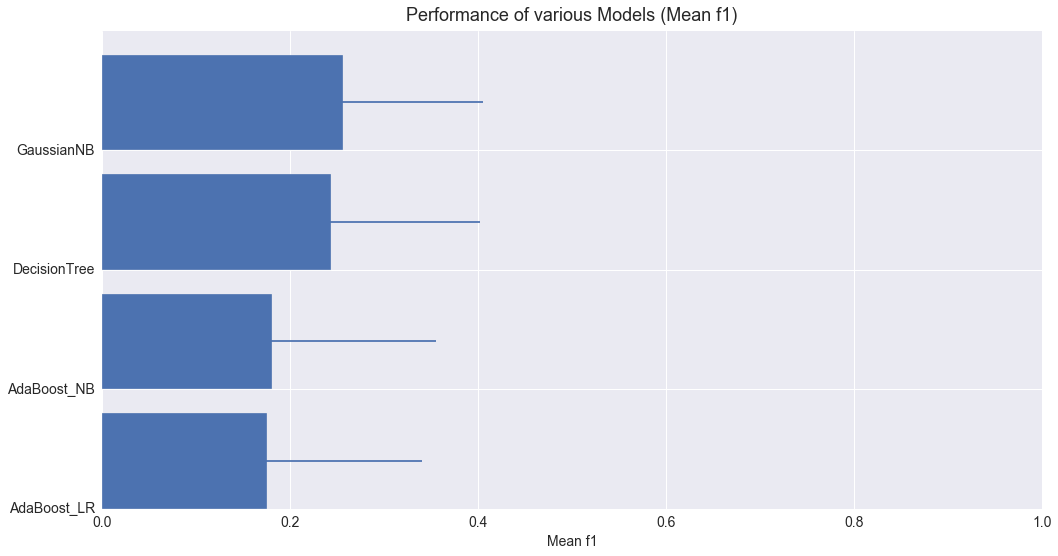

In [144]:
# Plotting model performance comparison

fig, ax = plt.subplots(figsize = (15,8))

rects1 = ax.barh(range(len(mp_df)), mp_df['Mean f1'],
                xerr=mp_df['Std'],
                tick_label=mp_df['Model'])

ax.set_xlabel('Mean f1', fontsize = 14)
ax.set_title('Performance of various Models (Mean f1)', fontsize = 18, y = 1.01)
#plt.yticks(rotation=75)
plt.tick_params(axis='both', labelsize = 14)
plt.xlim(0, 1);

### Chosen model, feature engineering and selection

Plain vanilla models were compared using cross validation and recall scores were used as the proxy. Adaboost and GradientBoost were chosen for further tuning.

All features were used for Principal Component Analysis, including the 3 additional features engineered. Using GridSearchCV, 4 principal components were used for the best model.

A pipeline was constructed to scale the features before modelling for standardization, this was done as the magnitude of the features differ widely, such as number of emails compared to bonus (several orders of magnitude).

## Tuning chosen model

In [41]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rand_state, stratify = y)

## Validation of models

Cross validation was used to compare the plain vanilla models. Pipeline was used to make sure there was no leakage of test information into training the models. This answers the question of the "classic mistake", where test data was used in training of models.

One important note was that feature scaling was performed after train/test split or cross validation in order to avoid leakage.

### Gridsearch GaussianNBClassifier

In [229]:
# Gridsearch for GaussianNB

pipe = make_pipeline(StandardScaler(), \
                    SelectKBest(), \
                    PCA(), \
                    GaussianNB()
                   )

k = [5,6,7,8, 9, 10, 11,12,13]
n_components = [2,3,4,5]

sss = StratifiedShuffleSplit(y, n_iter=100, test_size=0.3, random_state = rand_state)

clf = GridSearchCV(pipe, \
                    dict(selectkbest__k = k, \
                         pca__n_components=n_components), \
                    scoring= 'f1', cv=sss, n_jobs = -1
                   )



In [230]:
clf.fit(X, y)

/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=StratifiedShuffleSplit(labels=[ 0.  0. ...,  1.  0.], n_iter=100, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x10a82eb90>)), ('pca', PCA(copy=True, n_components=None, whiten=False)), ('gaussiannb', GaussianNB())]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'pca__n_components': [2, 3, 4, 5], 'selectkbest__k': [5, 6, 7, 8, 9, 10, 11, 12, 13]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [233]:
clf.best_params_

{'pca__n_components': 4, 'selectkbest__k': 10}

In [234]:
clf.best_score_

0.31950283050283046

In [236]:
list(X.columns[clf.best_estimator_.named_steps['selectkbest'].get_support()])

['bonus',
 'exercised_stock_options',
 'expenses',
 'from_poi_to_this_person',
 'other',
 'restricted_stock',
 'salary',
 'shared_receipt_with_poi',
 'total_payments',
 'total_stock_value']

### Gridsearch without PCA

In [237]:
# Gridsearch for GaussianNB

clf = make_pipeline(StandardScaler(), \
                    SelectKBest(), \
#                    PCA(), \
                    GaussianNB()
                   )

k = [5,6,7,8, 9, 10, 11,12,13]
#n_components = [2,3,4,5]

sss = StratifiedShuffleSplit(y, n_iter=100, test_size=0.3, random_state = rand_state)

gsab = GridSearchCV(clf, \
                    dict(selectkbest__k = k), \
#                         pca__n_components=n_components), \
                    scoring= 'f1', cv=sss, n_jobs = -1
                   )



In [238]:
gsab.fit(X, y)

/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=StratifiedShuffleSplit(labels=[ 0.  0. ...,  1.  0.], n_iter=100, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x10a82eb90>)), ('gaussiannb', GaussianNB())]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'selectkbest__k': [5, 6, 7, 8, 9, 10, 11, 12, 13]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [239]:
print gsab.best_params_
print gsab.best_score_

{'selectkbest__k': 7}
0.305247779998


In [240]:
list(X.columns[gsab.best_estimator_.named_steps['selectkbest'].get_support()])

['bonus',
 'exercised_stock_options',
 'restricted_stock',
 'salary',
 'shared_receipt_with_poi',
 'total_payments',
 'total_stock_value']

#### Comments:

PCA after selecting KBest seems to have better results.

### Gridsearch with feature union (Select K Best and PCA) without Scaling

In [241]:
pca = PCA()
kbest = SelectKBest()
gnb = GaussianNB()

combined_features = FeatureUnion([("kbest", kbest), ("pca", pca)])

pipeline = Pipeline([("features", combined_features), ("gnb", gnb)])
param_grid_neigh = dict(features__pca__n_components=[2,3,4,5],
                  features__kbest__k=[2,3,4,5,10])    
sss = StratifiedShuffleSplit(y, n_iter=100, test_size=0.3, random_state = rand_state)
clf = GridSearchCV(pipeline, param_grid=param_grid_neigh, scoring = 'f1', cv=sss)
clf.fit(X,y)

/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=StratifiedShuffleSplit(labels=[ 0.  0. ...,  1.  0.], n_iter=100, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x10a82eb90>)), ('pca', PCA(copy=True, n_components=None, whiten=False))],
       transformer_weights=None)), ('gnb', GaussianNB())]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'features__pca__n_components': [2, 3, 4, 5], 'features__kbest__k': [2, 3, 4, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [242]:
clf.best_score_

0.32629289827819241

In [244]:
# Get best features

list(X.columns[clf.best_estimator_.named_steps['features'].get_params()['kbest'].get_support()])

['bonus',
 'exercised_stock_options',
 'salary',
 'total_payments',
 'total_stock_value']

### GridSearch feature Union with SelectKBest and PCA with standard scaling

In [245]:
# Gridsearch for Adaboost

combined_features = FeatureUnion([("kbest", SelectKBest()), ("pca", PCA())])

k = [5,6,7,8, 9, 10, 11,12,13]
n_components = [2,3,4,5,6]

pipeline = Pipeline([("standard_scale", StandardScaler()),("features", combined_features), ("gnb", GaussianNB())])
param_grid_neigh = dict(features__pca__n_components=n_components, \
                  features__kbest__k=k)

# clf = GridSearchCV(pipeline, param_grid=param_grid_neigh, scoring = 'f1')
# clf.fit(X, y)

sss = StratifiedShuffleSplit(y, n_iter=100, test_size=0.3, random_state = rand_state)

gsab = GridSearchCV(pipeline, \
                    param_grid_neigh, \
                    scoring= 'f1', cv=sss, n_jobs = -1
                   )

In [246]:
gsab.fit(X,y)
print gsab.best_params_
print gsab.best_score_

{'features__pca__n_components': 3, 'features__kbest__k': 7}
0.334865911866


### GridSearch feature Union with SelectKBest and PCA with MinMax scaling

In [247]:
# Gridsearch for Adaboost

combined_features = FeatureUnion([("kbest", SelectKBest()), ("pca", PCA())])

k = [5,6,7,8, 9, 10, 11,12,13]
n_components = [2,3,4,5,6]

pipeline = Pipeline([("standard_scale", MinMaxScaler()),("features", combined_features), ("gnb", GaussianNB())])
param_grid_neigh = dict(features__pca__n_components=n_components, \
                  features__kbest__k=k)

# clf = GridSearchCV(pipeline, param_grid=param_grid_neigh, scoring = 'f1')
# clf.fit(X, y)

sss = StratifiedShuffleSplit(y, n_iter=100, test_size=0.3, random_state = rand_state)

gsab = GridSearchCV(pipeline, \
                    param_grid_neigh, \
                    scoring= 'f1', cv=sss, n_jobs = -1
                   )

In [248]:
gsab.fit(X,y)
print gsab.best_params_
print gsab.best_score_

{'features__pca__n_components': 2, 'features__kbest__k': 5}
0.33984107267


In [249]:
# Get best features

list(X.columns[gsab.best_estimator_.named_steps['features'].get_params()['kbest'].get_support()])

['bonus',
 'exercised_stock_options',
 'salary',
 'total_payments',
 'total_stock_value']

### GridSearch GaussianNB with self-created new features (Select K Best and PCA for all features)

In [142]:
# Gridsearch for Adaboost

combined_features = FeatureUnion([("kbest", SelectKBest()), ("pca", PCA())])

k = [3, 4,5,6,7,8, 9, 10, 11,12,13, 14, 15,16, 17]
n_components = [2,3,4,5,6,7,8]

pipeline = Pipeline([("standard_scale", MinMaxScaler()),("features", combined_features), ("gnb", GaussianNB())])
param_grid_neigh = dict(features__pca__n_components=n_components, \
                  features__kbest__k=k)

# clf = GridSearchCV(pipeline, param_grid=param_grid_neigh, scoring = 'f1')
# clf.fit(X, y)

sss = StratifiedShuffleSplit(y, n_iter=100, test_size=0.3, random_state = rand_state)

gsab = GridSearchCV(pipeline, \
                    param_grid_neigh, \
                    scoring= 'f1', cv=sss, n_jobs = -1
                   )

In [143]:
gsab.fit(X,y)
print gsab.best_params_
print gsab.best_score_
print gsab.best_estimator_

/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'features__pca__n_components': 2, 'features__kbest__k': 7}
0.317227772228
Pipeline(steps=[('standard_scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('kbest', SelectKBest(k=7, score_func=<function f_classif at 0x10a82eb90>)), ('pca', PCA(copy=True, n_components=2, whiten=False))],
       transformer_weights=None)), ('gnb', GaussianNB())])


In [160]:
# Get best features

list(X.columns[gsab.best_estimator_.named_steps['features'].get_params()['kbest'].get_support()])

['bonus',
 'exercised_stock_options',
 'salary',
 'total_payments',
 'total_stock_value',
 'to_poi_ratio',
 'shared_poi_ratio']

### Decision tree

In [165]:
# Gridsearch for Adaboost

combined_features = FeatureUnion([("kbest", SelectKBest()), ("pca", PCA())])

k = [3, 4,5,6,7,8, 9, 10, 11,12,13, 14, 15,16, 17]
n_components = [2,3,4,5,6,7,8]

pipeline = Pipeline([("standard_scale", MinMaxScaler()),("features", combined_features), \
                     ("tree", DecisionTreeClassifier(random_state=rand_state))])
param_grid_neigh = dict(features__pca__n_components=n_components, \
                  features__kbest__k=k)

# clf = GridSearchCV(pipeline, param_grid=param_grid_neigh, scoring = 'f1')
# clf.fit(X, y)

sss = StratifiedShuffleSplit(y, n_iter=100, test_size=0.3, random_state = rand_state)

gsab = GridSearchCV(pipeline, \
                    param_grid_neigh, \
                    scoring= 'f1', cv=sss, n_jobs = -1
                   )

In [166]:
gsab.fit(X,y)
print gsab.best_params_
print gsab.best_score_
print gsab.best_estimator_

/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'features__pca__n_components': 3, 'features__kbest__k': 9}
0.328173277703
Pipeline(steps=[('standard_scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('kbest', SelectKBest(k=9, score_func=<function f_classif at 0x10a82eb90>)), ('pca', PCA(copy=True, n_components=3, whiten=False))],
       transformer_weights=None)...plit=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'))])


In [167]:
# Get best features

list(X.columns[gsab.best_estimator_.named_steps['features'].get_params()['kbest'].get_support()])

['bonus',
 'exercised_stock_options',
 'restricted_stock',
 'salary',
 'total_payments',
 'total_stock_value',
 'shared_receipt_with_poi',
 'to_poi_ratio',
 'shared_poi_ratio']

## Gradient Boost

In [168]:
# Gridsearch for Adaboost

combined_features = FeatureUnion([("kbest", SelectKBest()), ("pca", PCA())])

k = [3, 4,5,6,7,8, 9, 10, 11,12,13, 14, 15,16, 17]
n_components = [2,3,4,5,6,7,8]
max_depth = [2,3,4,5,6,7,8]

pipeline = Pipeline([("standard_scale", MinMaxScaler()),("features", combined_features), \
                     ("gb", GradientBoostingClassifier(random_state=rand_state))])
param_grid_neigh = dict(features__pca__n_components=n_components, \
                        features__kbest__k=k, \
                        gb__max_depth = max_depth
                       )

# clf = GridSearchCV(pipeline, param_grid=param_grid_neigh, scoring = 'f1')
# clf.fit(X, y)

sss = StratifiedShuffleSplit(y, n_iter=100, test_size=0.3, random_state = rand_state)

gsab = GridSearchCV(pipeline, \
                    param_grid_neigh, \
                    scoring= 'f1', cv=sss, n_jobs = -1
                   )

In [169]:
gsab.fit(X,y)
print gsab.best_params_
print gsab.best_score_
print gsab.best_estimator_

/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'features__pca__n_components': 2, 'gb__max_depth': 2, 'features__kbest__k': 10}
0.329490953491
Pipeline(steps=[('standard_scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x10a82eb90>)), ('pca', PCA(copy=True, n_components=2, whiten=False))],
       transformer_weights=None...        presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False))])


In [170]:
# Get best features

list(X.columns[gsab.best_estimator_.named_steps['features'].get_params()['kbest'].get_support()])

['bonus',
 'exercised_stock_options',
 'expenses',
 'restricted_stock',
 'salary',
 'total_payments',
 'total_stock_value',
 'shared_receipt_with_poi',
 'to_poi_ratio',
 'shared_poi_ratio']

### With new features (Select K Best and PCA for all, finance and email features separately)

In [141]:
# Custom transformer to extract selected columns

class ColumnExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        col_list = []
        X = np.array(X)
        #print self.cols
        for c in self.cols:
            #print c
            col_list.append(X[:,c:c+1])
        return np.concatenate(col_list, axis=1)

    def fit(self, X, y=None, **fit_params):
        return self

In [161]:
# Gridsearch wtih selectKBest, PCA on all, PCA on finance and PCA on emails

combined_features = FeatureUnion([("kbest", SelectKBest()), \
                                  ("pca", PCA()), \
                                  ("pca_f", Pipeline([("col_ext_f", ColumnExtractor(cols = range(0,9))),\
                                                     ("pca_f_f", PCA())])), \
                                  ("pca_e", Pipeline([("col_ext_e", ColumnExtractor(cols = range(9,17))),\
                                                     ("pca_e_e", PCA())]))])

k = [5,6,7,8, 9, 10, 11,12,13, 14, 15, 16]
n_components = [2,3,4,5]

pipeline = Pipeline([("standard_scale", MinMaxScaler()),("features", combined_features), ("gnb", GaussianNB())])
param_grid_neigh = dict(features__pca__n_components=n_components, \
                  features__kbest__k=k, \
                       features__pca_f__pca_f_f__n_components = n_components, \
                        features__pca_e__pca_e_e__n_components = n_components)

sss = StratifiedShuffleSplit(y, n_iter=100, test_size=0.3, random_state = rand_state)

gsab = GridSearchCV(pipeline, \
                    param_grid_neigh, \
                    scoring= 'f1', cv=sss, n_jobs = -1
                   )

In [162]:
gsab.fit(X,y)
print gsab.best_params_
print gsab.best_score_
print gsab.best_estimator_

/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Peida/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'features__pca_f__pca_f_f__n_components': 4, 'features__pca_e__pca_e_e__n_components': 2, 'features__pca__n_components': 2, 'features__kbest__k': 6}
0.302533786819
Pipeline(steps=[('standard_scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('kbest', SelectKBest(k=6, score_func=<function f_classif at 0x10a82eb90>)), ('pca', PCA(copy=True, n_components=2, whiten=False)), ('pca_f', Pipeline(steps=[('col_e...=True, n_components=2, whiten=False))]))],
       transformer_weights=None)), ('gnb', GaussianNB())])


In [163]:
# Get best features

list(X.columns[gsab.best_estimator_.named_steps['features'].get_params()['kbest'].get_support()])

['bonus',
 'exercised_stock_options',
 'salary',
 'total_stock_value',
 'to_poi_ratio',
 'shared_poi_ratio']

## Modeling conclusion

Modeling was conducted in the following manner:

1. Compare plain vanilla model on all original features with less than 50% missing values.
2. Select best performing model (GaussianNB and Decision Tree) conduct GridsearchCV on serialized transformations:

    a. StandardScaling
    b. SelectKBest
    c. PCA
3. Conduct GridSearchCV on parallelized transformation:

    a. Standard or MinMax Scaling
    b1. SelectKBest on all original features
    b2. PCA on all original features
4. Repeat modeling process with new features (self-created ones)

5. Last approach tried was to separate create principal components for finance and email features and add these components to PCA conducted on all features and features selected using SelectKBest.

6. Models were compared based on f1 score using 100 folds stratifiedshufflesplit on the entire dataset. This was due to the small size of the data and the imbalance in the POI distribution, hence it would not be meaningful to use the traditional train/test/validation split or K-fold cross validation.

The best performing model was:

GaussianNB with MinMaxScaling and parallelized SelectKbest and PCA on all original feature with less than 50% missing values.

## What is model tuning?

Every algorithm or model has some arguments which can be varied for different performance values.

In this case, GaussianNB was chosen with SelectKbest and PCA. Parameters chosen for tuning were the number of components used from PCA and the number of features selected using SelectKBest.

Model tuning means changing these parameters (via GridSearchCV) and comparing the results after each change. Results here was chosen as f1 score instead of accuracy. Accuracy is not a good metric in this case since there are a strong imbalance in the classes, 88% non-poi compared with 12% POI. Simply by calling all test data a non-poi, the "model" would achieve a good accuracy score of about 88%, but failed in its intended use since it can never identify any POI.

F1 score takes the harmonic mean of precision and recall scores, and provides a more relevant metric to measure the performance of the models in this case. 

Recall is a measure of the model's ability to identify the POIs in the test set. It is the ratio of the number of correctly identified POIs over all POIs in the test set. If say, there were 5 POIs in the test set and the model managed to identify 2, the recall is 0.4.

Precision is the ratio of correctly identified POIs over sum of correctly identified POIs and incorrectly identified POIs. This serves as a kind of check to avoid the other extreme of calling all test data POI, which would achieve 1.0 recall but ends up with large number of wrongly identified non-POIs (calling a non-POI a POI). In the real world, such error would result in higher unnecessary work, such as in this case, the human investigator would have to interview a lot more non-POIs who were wrongly classified as POIs.

## Comments on new features

The chosen model ended up not using any of the newly created features, mainly due to performance considerations.

However, in the process of modeling, feature importance was checked for all models and the email ratios which were created were used in the SelectKBest feature selection process. Expense/Salary ratio, however, was never one of the selected features.

This was already evident in the boxplots earlier, after the creation of these features. The email ratios boxplots showed more discriminatory abilties than salary/expense ratio. POIs email ratios were quite different from non-POIs.

## What is validation and why is it important?

In ML, the traditional approach is to break up the dataset into train, test and validation set (about 0.7, 0.2, 0.1, but really depends on the characteristics of the dataset). The purpose is to hold out data when training the ML model so as to avoid overfitting.

The general process is to use the training set to fit a model, use the test set, which at this point was never seen by the model, to check the performance of the model. Re-tune the model if necessary, then use the validation set to check the performance of the model again.

Since we can never get a dataset which encompasses all possible scenarios, trying to tune a model to generate best performance using all the data may result in over-fitting, and the model being unable to generalize well to unseen data, hence resulting in poor real-world performance.

In the event when the dataset is huge, separating it into the 3 sets in a random manner would be feasible. However, when the dataset is small, we may need to use cross-validation (usually k-fold cross-validation), where the dataset may be separated into 2 (train/test set and validation set). Within the train/test set, the data is sliced into a number of smaller set (k-fold), say 5. The cross-validation process then holds out 1 of the 5 sets as a test set, train the model with the remaining 4 datasets and use the 1 to test the model. The process repeats this method for k (5 in this case) times so that each of the k set "gets a turn" to be the test set. The performance metric is then averaged over k times to provide an average score.

Then there is this case of even smaller dataset with imbalanced classes. Using k-fold cross-validation may not be possible since it is likely the folds end up without some or 1 class of the data. I.e. the model was trained only on non-POI data. In this case, we had to use stratifiedshuffle split and give up the concept of a validation dataset, since holding out on precious POIs for validation means the training process loses significant portion of "learning materials" on the POIs, hence resulting in an over-generalized model.

Therefore, in this case, the entire dataset was used for the stratifiedshufflesplit. Stratifiedshufflesplit was used also because the process ensures that the classes are always split in the required manner. In my model, I used a 0.7/0.3 split and 100 folds. This means that each time the data is split to train and test set, there would be 30% of the POIs in the test set and 70% of the POIs in the training set. However, this process doesn't guarantee that each split is unique. This is overcame by the 100 folds (or possibly more folds, if computational power is available).

It is worthy to note that once the dataset get large, cross-validation (k-fold or stratified) becomes a computationally expensive affair and the marginal increment in model performance may not be justified.

## Converting to correct format for grading

In [252]:
df.T[df.columns.isin(want_list)].T.head()

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,poi,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
name,,,,,,,,,,,,,,
ALLEN PHILLIP K,4.175e+06,1.72954e+06,13868,2195,47,65,152,0,126027,201955,1407,2902,4.48444e+06,1.72954e+06
BADUM JAMES P,0,257817,3486,0,0,0,0,0,0,0,0,0,182466,257817
BAXTER JOHN C,1.2e+06,6.68054e+06,11200,0,0,0,2.6603e+06,0,3.94271e+06,267102,0,0,5.63434e+06,1.06233e+07
BAY FRANKLIN R,400000,0,129142,0,0,0,69,0,145796,239671,0,0,827696,63014
BAZELIDES PHILIP J,0,1.59964e+06,0,0,0,0,874,0,0,80818,0,0,860136,1.59964e+06


In [259]:
want_list

['poi',
 'total_stock_value',
 'total_payments',
 'restricted_stock',
 'exercised_stock_options',
 'expenses',
 'salary',
 'other',
 'to_messages',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'bonus']

In [268]:
data_d = df.T[df.columns.isin(want_list)].to_dict()
my_dataset = data_d

In [269]:
my_dataset

{'ALLEN PHILLIP K': {'bonus': 4175000.0,
  'exercised_stock_options': 1729541.0,
  'expenses': 13868.0,
  'from_messages': 2195.0,
  'from_poi_to_this_person': 47.0,
  'from_this_person_to_poi': 65.0,
  'other': 152.0,
  'poi': 0.0,
  'restricted_stock': 126027.0,
  'salary': 201955.0,
  'shared_receipt_with_poi': 1407.0,
  'to_messages': 2902.0,
  'total_payments': 4484442.0,
  'total_stock_value': 1729541.0},
 'BADUM JAMES P': {'bonus': 0.0,
  'exercised_stock_options': 257817.0,
  'expenses': 3486.0,
  'from_messages': 0.0,
  'from_poi_to_this_person': 0.0,
  'from_this_person_to_poi': 0.0,
  'other': 0.0,
  'poi': 0.0,
  'restricted_stock': 0.0,
  'salary': 0.0,
  'shared_receipt_with_poi': 0.0,
  'to_messages': 0.0,
  'total_payments': 182466.0,
  'total_stock_value': 257817.0},
 'BAXTER JOHN C': {'bonus': 1200000.0,
  'exercised_stock_options': 6680544.0,
  'expenses': 11200.0,
  'from_messages': 0.0,
  'from_poi_to_this_person': 0.0,
  'from_this_person_to_poi': 0.0,
  'other': 

In [270]:
clf = gsab.best_estimator_

features_list = list(X.columns)

In [271]:
features_list = ['poi'] + features_list

In [272]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

In [273]:
dataset = my_dataset
feature_list = features_list

In [11]:
#!/usr/bin/pickle

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()


Pipeline(steps=[('standard_scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('kbest', SelectKBest(k=5, score_func=<function f_classif at 0x114d88848>)), ('pca', PCA(copy=True, n_components=2, whiten=False))],
       transformer_weights=None)), ('gnb', GaussianNB())])
	Accuracy: 0.84433	Precision: 0.40637	Recall: 0.36350	F1: 0.38374	F2: 0.37134
	Total predictions: 15000	True positives:  727	False positives: 1062	False negatives: 1273	True negatives: 11938

